# Model Iteration 1
Pratool Gadtaula

Load the Titanic data file and get a quick look at what the data looks like

In [11]:
%matplotlib inline

import pandas

tdf = pandas.read_csv("train.csv")

print tdf.head(5)
print tdf.describe()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
       P

The sex column does not have numerical values, but could be useful for the predictive algorithm. In order to assign numerical values, the number of unique sex identifiers must be determined.

In [12]:
print tdf["Sex"].unique()

['male' 'female']


The data needs to be cleaned: missing values are filled with some form of center, typically median. The sex parameter is switched from strings specifying male and female to 0 and 1 respectively.

In [13]:
tdf.loc[tdf["Sex"] == "male", "Sex"] = 0
tdf.loc[tdf["Sex"] == "female", "Sex"] = 1

tdf["Age"] = tdf["Age"].fillna(tdf["Age"].median())

The embarked column may also yield useful information for the machine learning algorithm. So these values are also converted to a number of unique numerical values.

In [14]:
print tdf["Embarked"].unique()

['S' 'C' 'Q' nan]


The embarked column has "nan" values that need to be removed. The histogram is plotted to understand which measure of center would be best. In order to plot the histogram, the values are converted to numbers with S=0, C=1, Q=2, and nan=3.

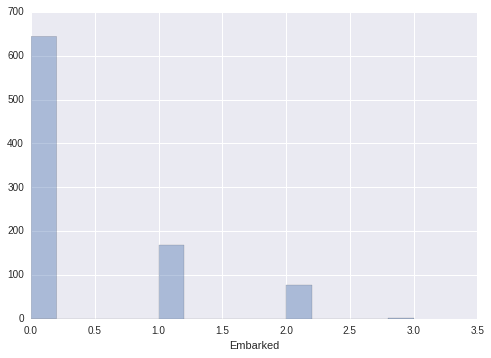

In [16]:
import seaborn as sns

tdf.loc[tdf["Embarked"] == "S", "Embarked"] = 0
tdf.loc[tdf["Embarked"] == "C", "Embarked"] = 1
tdf.loc[tdf["Embarked"] == "Q", "Embarked"] = 2
tdf["Embarked"] = tdf["Embarked"].fillna(3)

sns.distplot(tdf["Embarked"], kde=False);

From this graph, it looks like the mode and median are both 'S', so the nan values are filled with 0.

In [17]:
tdf.loc[tdf["Embarked"] == 3, "Embarked"] = 0

Using the scikit-learn library to split up the data into cross-validation folds, the linear regression algorithm performs supervised learning based on the cleaned data.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold

# the data columns that I'll use to predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

alg = LinearRegression()

# generate cross validation folds
kf = KFold(tdf.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = tdf[predictors].iloc[train,:]
    train_target = tdf["Survived"].iloc[train]
    
    # training the algorithm using the predictors and the target
    alg.fit(train_predictors, train_target)
    
    test_predictions = alg.predict(tdf[predictors].iloc[test,:])
    predictions.append(test_predictions)

Now that the model has made predictions on test data, the error can be evaluated as the number of correct predictions of the survival of each person out of the total number of people.

In [24]:
import numpy as np

predictions = np.concatenate(predictions, axis=0)

# map predictions to outcomes
predictions[predictions > .5] = 1
predictions[predictions <= .5] = 0

accuracy = sum(predictions == tdf["Survived"]) / float(len(predictions))

print accuracy

0.783389450056


Instead of performing a linear regression, a different machine learning algorithm called logistic regression is applied. This algorithm is better suited to the outcome as it outputs values between 0 and 1, just like the survived column of the data set.

In [29]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

alg = LogisticRegression(random_state=1)

# compute the accuracy score for all cross validation folds
scores = cross_validation.cross_val_score(alg, tdf[predictors], tdf["Survived"], cv=3)

# take the mean of the scores
print scores.mean()

0.787878787879


Now that I have a first-iteration model, I'll load and clean the test data to generate a submission file with the predictions and passenger IDs.

In [32]:
tdf_test = pandas.read_csv("test.csv")

tdf_test["Age"] = tdf_test["Age"].fillna(tdf["Age"].median())
tdf_test["Embarked"] = tdf_test["Embarked"].fillna('S')
tdf_test.loc[tdf_test["Embarked"] == 'S', "Embarked"] = 0
tdf_test.loc[tdf_test["Embarked"] == 'C', "Embarked"] = 1
tdf_test.loc[tdf_test["Embarked"] == 'Q', "Embarked"] = 2
tdf_test.loc[tdf_test["Sex"] == "male", "Sex"] = 0
tdf_test.loc[tdf_test["Sex"] == "female", "Sex"] = 1
tdf_test["Fare"] = tdf_test["Fare"].fillna(tdf_test["Fare"].median())

alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(tdf[predictors], tdf["Survived"])

# Make predictions using the test set.
predictions = alg.predict(tdf_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pandas.DataFrame({
        "PassengerId": tdf_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kaggle.csv", index=False)